Convert the 3D Nifti volumes from the BraTS2020 dataset into 2D slices and split into cross-validation folds

In [1]:
DATADIR = '/archive/bioinformatics/DLLab/STUDIES/BraTS2020_20201231/MICCAI_BraTS2020_TrainingData'
SEED = 334
MINVOX = 100 # minimum number of tumor voxels per extracted slice
OUTDIR = '/archive/bioinformatics/DLLab/KevinNguyen/data/BraTS2020_withedema'

In [2]:
import os
import sys
import glob
import pandas as pd
# from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
sys.path.append('../../')
from medl.grouped_cv import StratifiedGroupKFold, StratifiedGroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
import nibabel
import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# metadata files
dfNames = pd.read_csv(os.path.join(DATADIR, 'name_mapping.csv'), index_col=5)
dfSurvival = pd.read_csv(os.path.join(DATADIR, 'survival_info.csv'), index_col=0)
dfMetadata = dfNames.join(dfSurvival)
dfMetadata.head()

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,Age,Survival_days,Extent_of_Resection
BraTS_2020_subject_ID,,,,,,,,
BraTS20_Training_001,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,60.463,289,GTR
BraTS20_Training_002,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,52.263,616,GTR
BraTS20_Training_003,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,54.301,464,GTR
BraTS20_Training_004,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,39.068,788,GTR
BraTS20_Training_005,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,68.493,465,GTR


From each image, get axial slices that have at least `MINVOX` tumor voxels

In [4]:
def get_img_slices(strSubject, strModality, arrSlices):
    strImgPath = os.path.join(DATADIR, strSubject, strSubject + '_' + strModality + '.nii')
    arrImg = nibabel.load(strImgPath).get_data()
    return np.moveaxis(arrImg[..., arrSlices], -1, 0)

lsSlicesT1 = []
lsSlicesT1ce = []
lsSlicesT2 = []
lsSlicesFLAIR = []
lsSlicesMask = []
lsSubject = []

for strSubject in tqdm.tqdm(dfMetadata.index, total=dfMetadata.shape[0]):
    strSegPath = os.path.join(DATADIR, strSubject, strSubject + '_seg.nii')

    imgSeg = nibabel.load(strSegPath)
    arrSeg = imgSeg.get_data()
    # Get a mask for just the tumor (label 1 is the non-enhancing/necrotic core and label 4 is the enhancing region)
    arrMask = np.zeros_like(arrSeg)
    arrMask[arrSeg == 1] = 1
    arrMask[arrSeg == 4] = 1
    # # Get mask for tumor plus surrounding edema 
    # arrMask = (arrSeg > 0)
    # Find the number of tumor voxels in each axial slice
    arrVoxelCount = arrMask.sum(axis=(0, 1))
    arrSliceIdx = np.where(arrVoxelCount >= MINVOX)[0]

    lsSlicesT1 += [get_img_slices(strSubject, 't1', arrSliceIdx)]
    lsSlicesT1ce += [get_img_slices(strSubject, 't1ce', arrSliceIdx)]
    lsSlicesT2 += [get_img_slices(strSubject, 't2', arrSliceIdx)]
    lsSlicesFLAIR += [get_img_slices(strSubject, 'flair', arrSliceIdx)]
    lsSlicesMask += [np.moveaxis(arrMask[..., arrSliceIdx], -1, 0)]
    lsSubject += [strSubject] * arrSliceIdx.shape[0]

arrSlicesT1 = np.concatenate(lsSlicesT1, axis=0)
arrSlicesT1ce = np.concatenate(lsSlicesT1ce, axis=0)
arrSlicesT2 = np.concatenate(lsSlicesT2, axis=0)
arrSlicesFLAIR = np.concatenate(lsSlicesFLAIR, axis=0)
arrSlicesMask = np.concatenate(lsSlicesMask, axis=0)


100%|██████████| 369/369 [04:15<00:00,  1.45it/s]


Show some example contrast-enhanced T1 images overlaid with the tumor mask

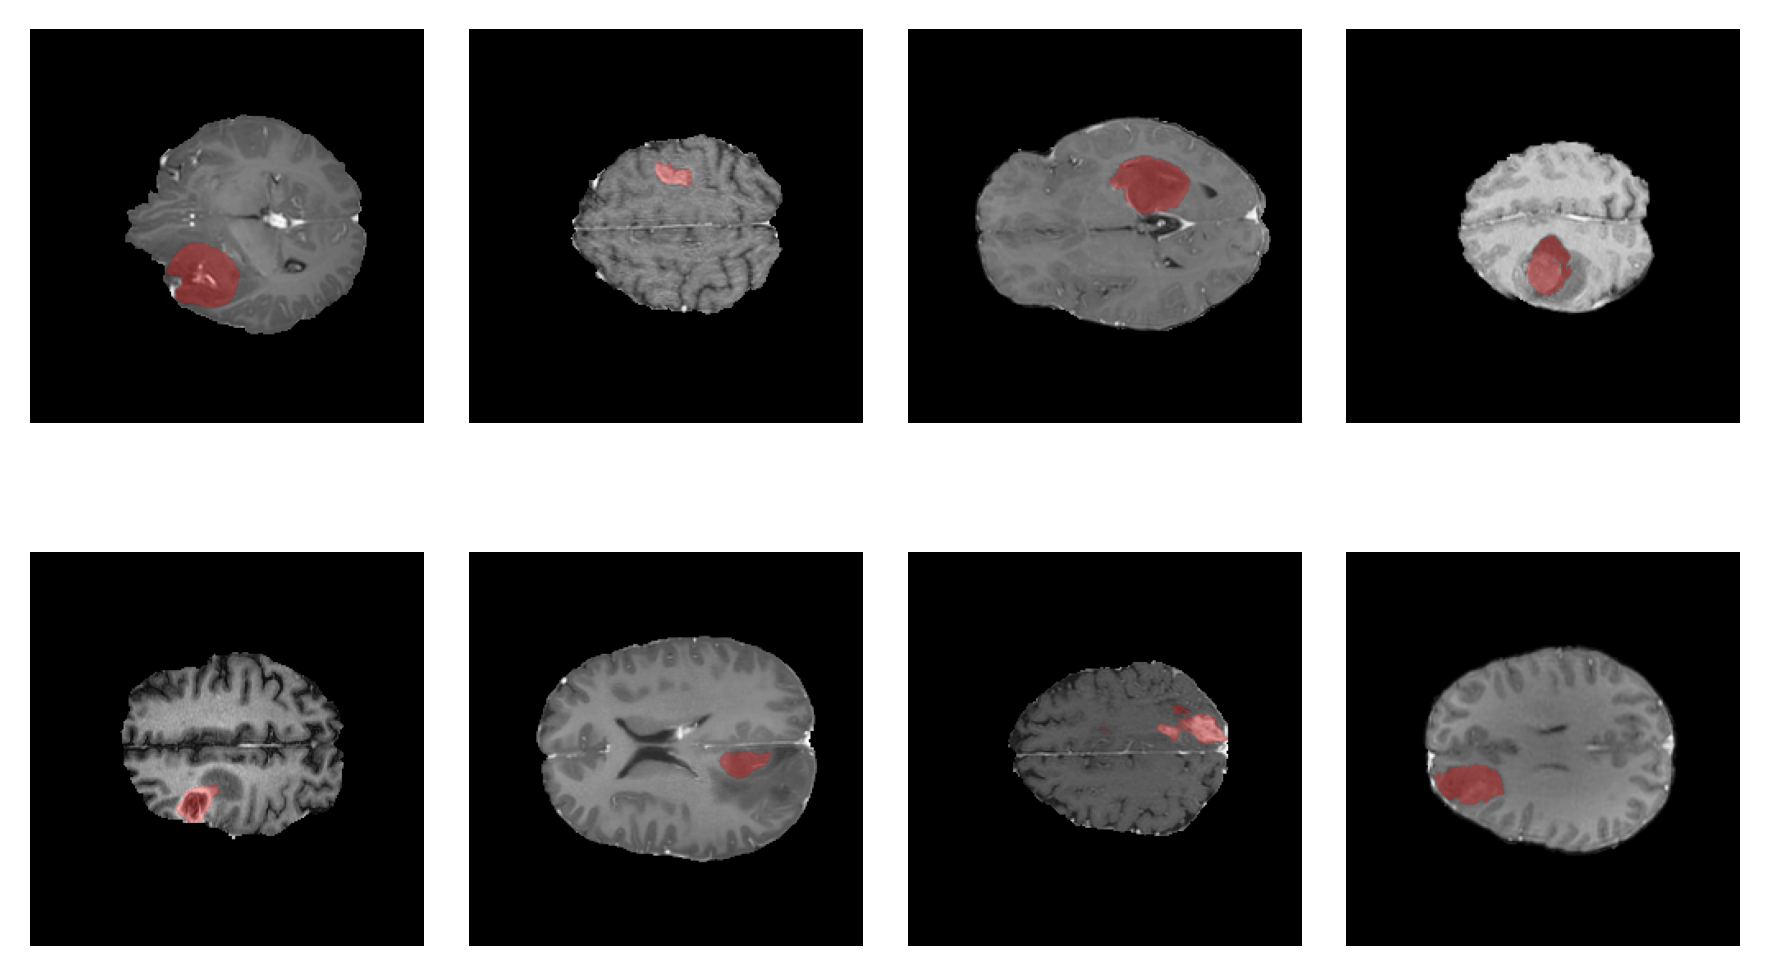

In [5]:
fig, ax = plt.subplots(2, 4, dpi=300)
for i in range(8):
    j = np.random.randint(arrSlicesT1ce.shape[0])
    ax.flatten()[i].imshow(arrSlicesT1ce[j,], cmap='Greys_r')
    arrOverlay = np.zeros(arrSlicesMask.shape[1:] + (4,))
    arrMask = arrSlicesMask[j,]
    arrOverlay[..., 0] = arrMask
    arrOverlay[..., -1] = arrMask
    ax.flatten()[i].imshow(arrOverlay, cmap='Reds', alpha=0.3)
    ax.flatten()[i].axis('off')
plt.tight_layout()
plt.show()

Train size: 11997
Test size: 2828


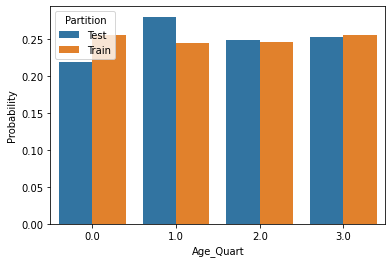

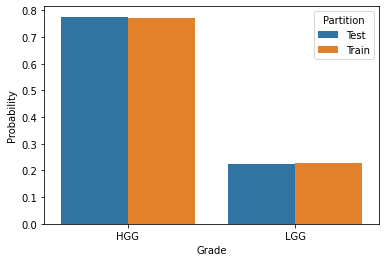

In [6]:
# Partition subjects first into 80% train and 20% test, then partition train into 5 folds. 
# Stratify partitions by tumor grade and age
dfStrat = dfMetadata['Grade'].to_frame('Grade')
dfStrat['Age_Quart'] = pd.qcut(dfMetadata['Age'], q=4, labels=False)
# dfStrat['Survival_Quart'] = pd.qcut(pd.to_numeric(dfMetadata['Survival_days'], 'coerce', 'integer'), 
#                                     q=3, labels=False)
# Assign each subject into a group labeled as tumorgrade_age_survival
dfStrat['Stratum'] = dfStrat.apply(lambda x: '_'.join([str(xi) for xi in x]), axis=1)
dfStrat = dfStrat.loc[lsSubject]

# Convert strata and subject IDs to integer labels
encoderSubject = LabelEncoder()
arrSubjects = encoderSubject.fit_transform(np.array(lsSubject).reshape(-1, 1))
encoderStrata = LabelEncoder()
arrStrat = encoderStrata.fit_transform(dfStrat['Stratum'])

splitTest = StratifiedGroupShuffleSplit(test_size=0.2, random_state=SEED)
arrTrainIdx, arrTestIdx = next(splitTest.split(dfStrat.index, arrStrat, groups=arrSubjects))
print('Train size:', arrTrainIdx.shape[0])
print('Test size:', arrTestIdx.shape[0])

# Ensure that stratification worked
dfStrat['Partition'] = 'Train'
dfStrat['Partition'].iloc[arrTestIdx] = 'Test'
dfAge = dfStrat.groupby('Partition')['Age_Quart'].value_counts(normalize=True)
dfAge = dfAge.to_frame('Probability')
dfAge = dfAge.reset_index()
sns.barplot(data=dfAge, x='Age_Quart', y='Probability', hue='Partition')
plt.show()

dfGrade = dfStrat.groupby('Partition')['Grade'].value_counts(normalize=True)
dfGrade = dfGrade.to_frame('Probability')
dfGrade = dfGrade.reset_index()
sns.barplot(data=dfGrade, x='Grade', y='Probability', hue='Partition')
plt.show()


In [7]:
dictData = {'t1': np.expand_dims(arrSlicesT1, 3).astype(np.int),
            't1ce': np.expand_dims(arrSlicesT1ce, 3).astype(np.int),
            't2': np.expand_dims(arrSlicesT2, 3).astype(int), 
            'flair': np.expand_dims(arrSlicesFLAIR, 3).astype(int),
            'mask': np.expand_dims(arrSlicesMask, 3).astype(int),
            'subject': arrSubjects}
dictTrainTest = {}
for strModality in dictData.keys():
    dictTrainTest[strModality + '_train'] = dictData[strModality][arrTrainIdx,]
    dictTrainTest[strModality + '_test'] = dictData[strModality][arrTestIdx,]
np.savez(os.path.join(OUTDIR, 'train_test.npz'), **dictTrainTest)



In [8]:
dictTrainTest['t1_test'].shape

(2828, 240, 240, 1)

In [9]:
splitVal = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
dfStratTrain = dfStrat.iloc[arrTrainIdx]
arrStratTrain = arrStrat[arrTrainIdx,]
arrSubjectsTrain = arrSubjects[arrTrainIdx,]
for iFold, (arrInnerTrainIdx, arrValIdx) in enumerate(splitVal.split(dfStratTrain.index, arrStratTrain, groups=arrSubjectsTrain)):
    dictInner = {}
    for strModality in dictData.keys():
        dictInner[strModality + '_train'] = dictTrainTest[strModality + '_train'][arrInnerTrainIdx,]
        dictInner[strModality + '_val'] = dictTrainTest[strModality + '_train'][arrValIdx,]
    np.savez(os.path.join(OUTDIR, f'fold{iFold}.npz'), **dictInner)



In [10]:
# Count the number of axial slices with >= 50 tumor voxels in each subject
arrSliceCount = np.zeros((dfMetadata.shape[0],))
for i, strSubject in enumerate(dfMetadata.index):
    strSegPath = os.path.join(DATADIR, strSubject, strSubject + '_seg.nii')
    imgSeg = nibabel.load(strSegPath)
    arrSeg = imgSeg.get_data()
    # Get a mask for just the tumor (label 1 is the non-enhancing/necrotic core and label 4 is the enhancing region)
    arrMask = np.zeros_like(arrSeg)
    arrMask[arrSeg == 1] = 1
    arrMask[arrSeg == 4] = 1
    # Find the number of tumor voxels in each axial slice
    arrVoxelCount = arrMask.sum(axis=(0, 1))
    arrSliceCount[i] = np.sum(arrVoxelCount >= 50)
print('Mean slices/subject with >= 50 tumor vox:', arrSliceCount.mean())
print('Min slices/subject with >= 50 tumor vox:', arrSliceCount.min())

Mean slices/subject with >= 50 tumor vox: 42.00813008130081
Min slices/subject with >= 50 tumor vox: 6.0
